# DATA CLEANING

## Predicting Price of Diamonds

The aim of the project is to build a machine learning model to predict the price of diamonds based on different explanatory variables describing aspects of diamonds.


We aim to minimise the difference between the real price, and the estimated price by our model. We will evaluate model performance using the mean squared error (mse) and the root squared of the mean squared error (rmse).



====================================================================================================

In [2]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [3]:
# load dataset
data = pd.read_csv('diamonds.csv')
print(data.shape)
data.head()

(53940, 11)


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### Separate dataset into train and test



In [4]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data, data.price,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((48546, 11), (5394, 11))

### Missing values

In [5]:
# make a list of the categorical variables that contain missing values
vars_with_na = [var for var in data.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes=='O']

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(X_train[var].isnull().mean(), 3),  ' % missing values')

In [6]:
# function to replace NA in categorical variables
def fill_categorical_na(df, var_list):
    X = df.copy()
    X[var_list] = df[var_list].fillna('Missing')
    return X

In [7]:
# replace missing values with new label: "Missing"
X_train = fill_categorical_na(X_train, vars_with_na)
X_test = fill_categorical_na(X_test, vars_with_na)

# check that we have no missing information in the engineered variables
X_train[vars_with_na].isnull().sum()

Series([], dtype: float64)

In [8]:
# check that test set does not contain null values in the engineered variables
[vr for var in vars_with_na if X_train[var].isnull().sum()>0]

[]

### Numerical variables

We will log transform the numerical variables that do not contain zeros in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models. 

In [13]:
data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [14]:
for var in ['carat', 'depth', 'table', 'price', 'x','y', 'z']:
    X_train[var] = np.log(X_train[var])
    X_test[var]= np.log(X_test[var])

C:\Users\Ulises Cabrera\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Ulises Cabrera\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# check that test set does not contain null values in the engineered variables
[var for var in ['carat', 'depth', 'table', 'price', 'x','y', 'z'] if X_test[var].isnull().sum()>0]

[]

In [16]:
# same for train set
[var for var in ['carat', 'depth', 'table', 'price', 'x','y', 'z'] if X_train[var].isnull().sum()>0]

[]

### Categorical variables

First, we will remove those categories within variables that are present in less than 1% of the observations:

In [17]:
# let's capture the categorical variables first
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

In [18]:
def find_frequent_labels(df, var, rare_perc):
    # finds the labels that are shared by more than a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)['price'].count() / len(df)
    return tmp[tmp>rare_perc].index

for var in cat_vars:
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

Next, we need to transform the strings of these variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target:

In [19]:
# this function will assign discrete values to the strings of the variables, 
# so that the smaller value corresponds to the smaller mean of target

def replace_categories(train, test, var, target):
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [20]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'price')

In [21]:
# check absence of na
[var for var in X_train.columns if X_train[var].isnull().sum()>0]

[]

In [22]:
# check absence of na
[var for var in X_test.columns if X_test[var].isnull().sum()>0]

[]

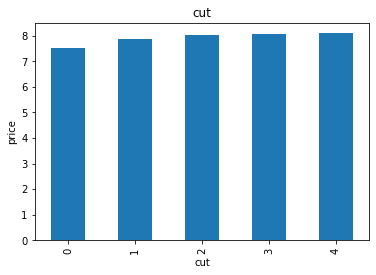

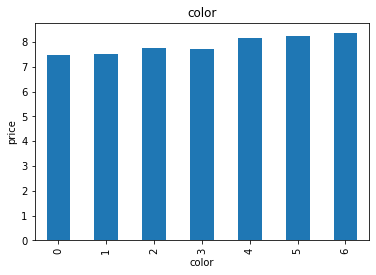

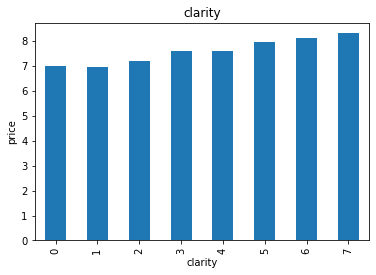

In [24]:
def analyse_vars(df, var):
    df = df.copy()
    df.groupby(var)['price'].median().plot.bar()
    plt.title(var)
    plt.ylabel('price')
    plt.show()
    
for var in cat_vars:
    analyse_vars(X_train, var)

### Feature Scaling

In [25]:
train_vars = [var for var in X_train.columns if var not in ['Unnamed: 0', 'price']]
len(train_vars)

9

In [26]:
X_train[['Unnamed: 0', 'price']].reset_index(drop=True)

,Unnamed: 0,price
0,37975,6.914731
1,45367,7.417580
2,34602,6.152733
3,32114,6.663133
4,22779,9.287301
5,41248,7.096721
6,27771,6.473891
7,4007,8.165932
8,52241,7.818028
9,25465,9.563178


In [28]:
X_train.head(10)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
37974,37975,-0.916291,2,3,4,4.155753,4.077537,6.914731,1.534714,1.519513,1.078410
45366,45367,-0.597837,0,0,4,4.119037,4.043051,7.417580,1.658228,1.665818,1.175573
34601,34602,-1.309333,1,0,3,4.100989,4.077537,6.152733,1.430311,1.435085,0.928219
32113,32114,-1.386294,0,0,0,4.131961,3.970292,6.663133,1.406097,1.413423,0.936093
22778,22779,0.009950,1,2,1,4.080922,4.094345,9.287301,1.868721,1.885553,1.353255
41247,41248,-0.616186,0,4,7,4.114147,4.025352,7.096721,1.662030,1.656321,1.166271
27770,27771,-1.139434,0,4,4,4.127134,4.007333,6.473891,1.481605,1.477049,1.000632
4006,4007,-0.105361,1,2,7,4.112512,3.988984,8.165932,1.835776,1.838961,1.345472
52240,52241,-0.314711,0,5,2,4.147885,4.043051,7.818028,1.752672,1.745716,1.291984
25464,25465,0.336472,0,3,2,4.127134,4.025352,9.563178,1.971299,1.964311,1.490654


In [30]:
# check absence of missing values
X_train.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [60]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('xtrain.csv', index=False)
X_test.to_csv('xtest.csv', index=False)